In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
import sys
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv(r"../../Dataset/NCA Preprocessed/master_features_nca.csv")
df

filename  cell_id  temp  charge_rate  discharge_rate  cycle  \
0      CY25-025_1-#1.csv        1    25         0.25             1.0      1   
1      CY25-025_1-#1.csv        1    25         0.25             1.0      2   
2      CY25-025_1-#1.csv        1    25         0.25             1.0      3   
3      CY25-025_1-#1.csv        1    25         0.25             1.0      4   
4      CY25-025_1-#1.csv        1    25         0.25             1.0      5   
...                  ...      ...   ...          ...             ...    ...   
22639   CY45-05_1-#9.csv        9    45         0.50             1.0    411   
22640   CY45-05_1-#9.csv        9    45         0.50             1.0    412   
22641   CY45-05_1-#9.csv        9    45         0.50             1.0    413   
22642   CY45-05_1-#9.csv        9    45         0.50             1.0    414   
22643   CY45-05_1-#9.csv        9    45         0.50             1.0    415   

          SOH  IC_bin_1  IC_bin_2  IC_bin_3  ...  IC_bin_11  IC_bin_12  \
0       99.96  3.206253  3.435524  3.772510  ...   4.255246   4.207070   
1       99.98  3.185611  3.409977  3.737496  ...   4.249921   4.223132   
2      100.00  3.166235  3.397673  3.713245  ...   4.235653   4.189766   
3       99.97  3.139468  3.376350  3.683448  ...   4.254307   4.162355   
4       99.93  3.132129  3.346752  3.653736  ...   4.216513   4.164974   
...       ...       ...       ...       ...  ...        ...        ...   
22639   84.65  2.514883  2.565545  2.627766  ...   3.248165   3.376864   
22640   84.61  2.510205  2.560754  2.625429  ...   3.250500   3.392370   
22641   84.60  2.513525  2.562124  2.623266  ...   3.245492   3.372555   
22642   84.58  2.508238  2.557557  2.619624  ...   3.241048   3.372799   
22643   84.55  2.509477  2.557809  2.618544  ...   3.239394   3.363069   

       IC_bin_13  IC_bin_14  IC_bin_15  IC_bin_16  IC_bin_17  IC_bin_18  \
0       4.229390   4.248806   4.264151   4.198406   4.058616   3.920543   
1       4.181276   4.225006   4.231327   4.158785   4.055173   3.905594   
2       4.140167   4.167926   4.180849   4.145106   4.015124   3.896722   
3       4.134256   4.143371   4.135573   4.118733   4.023064   3.867330   
4       4.094929   4.101335   4.135343   4.100581   4.008745   3.881142   
...          ...        ...        ...        ...        ...        ...   
22639   3.545380   3.705835   3.774339   3.705556   3.564230   3.413748   
22640   3.559592   3.706725   3.763518   3.694866   3.559024   3.417873   
22641   3.540142   3.694258   3.752898   3.692722   3.562536   3.425323   
22642   3.540815   3.700767   3.761809   3.701606   3.569719   3.425509   
22643   3.529577   3.692710   3.758408   3.703477   3.570270   3.425148   

       IC_bin_19  IC_bin_20  
0       3.792856   3.647914  
1       3.737473   3.648392  
2       3.756668   3.646670  
3       3.752034   3.631178  
4       3.761407   3.626212  
...          ...        ...  
22639   3.287599   3.193869  
22640   3.299083   3.207045  
22641   3.303745   3.206924  
22642   3.299934   3.202914  
22643   3.298753   3.200880  

[22644 rows x 27 columns]

In [3]:
import sys
sys.path.append("../../")
from preprocessing.data_preprocessor import DataPreprocessor


preprocessor = DataPreprocessor(
    train_size=0.8,
    ic_low=0,
    ic_high=20
)

data = preprocessor.preprocess(df)

X_ic_train = data["X_ic_train"]
X_context_train = data["X_context_train"]
y_train = data["y_train"]


print("Train Data shape:")
print("X_ic_train shape:", X_ic_train.shape)
print("X_context_train shape:", X_context_train.shape)
print("y_train shape:",y_train.shape)


Train Data shape:
X_ic_train shape: (18109, 20, 1)
X_context_train shape: (18109, 7)
y_train shape: (18109,)


In [4]:
X_ic_test = data['X_ic_test']
X_context_test = data['X_context_test']
y_test_norm = data['y_test']

y_mean = data['y_mean']
y_std = data['y_std']

print("Test data shape:")
print("X_ic_test shape:", X_ic_test.shape)
print("X_context_test shape:", X_context_test.shape)
print("Y_test shape:", y_test_norm.shape)

Test data shape:
X_ic_test shape: (4528, 20, 1)
X_context_test shape: (4528, 7)
Y_test shape: (4528,)


__FGSM ATTACK__

In [5]:
from utils.attacks import fgsm_attack_batch

__Model Metrics__

In [6]:
def attack_eval(
    model,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    epsilon,
    attack_fn,
    clip_min, clip_max, scaler_std,
    model_name="",
    plot=True
):
    # Generate adversarial samples
    X_ic_test_adv = attack_fn(
        model,
        X_ic_test,
        X_context_test,
        y_test_norm,    
        scaler_std,
        epsilon,
        clip_min,
        clip_max
    )

    # Predictions (normalized)
    y_pred_norm = model.predict([X_ic_test, X_context_test], verbose=0).flatten()
    y_pred_adv_norm = model.predict([X_ic_test_adv, X_context_test], verbose=0).flatten()

    # Inverse scaling (REAL SOH)
    y_test = y_test_norm * y_std + y_mean
    y_pred = y_pred_norm * y_std + y_mean
    y_pred_adv = y_pred_adv_norm * y_std + y_mean

    # Metrics
    mae_clean = mean_absolute_error(y_test, y_pred)
    mae_adv = mean_absolute_error(y_test, y_pred_adv)
    delta_mae = mae_adv - mae_clean

    mape_clean = mean_absolute_percentage_error(y_test, y_pred)
    mape_adv = mean_absolute_percentage_error(y_test, y_pred_adv)

    # Optional plots
    if plot:
        plt.figure(figsize=(16,6))

        plt.subplot(1,2,1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Clean ")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.subplot(1,2,2)
        plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Attacked (ε={epsilon})")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.show()

    return {
        "MAE_clean": mae_clean,
        "MAE_adv": mae_adv,
        "ΔMAE": delta_mae,
        "MAPE_clean": mape_clean,
        "MAPE_adv": mape_adv
    }

In [7]:
from tabulate import tabulate

def run_attack_evaluation(
    model,
    model_name,
    attack_fn,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    eps_values,
    clip_min, clip_max,
    scaler_std,
    plot=False
):
    """
    Runs adversarial attack evaluation for a given model
    and prints results in tabular form.
    """

    results = []

    for eps in eps_values:
        res = attack_eval(
            model=model,
            X_ic_test=X_ic_test,
            X_context_test=X_context_test,
            y_test_norm=y_test_norm,
            y_std=y_std,
            y_mean=y_mean,
            epsilon=eps,
            attack_fn=attack_fn,
            model_name=model_name,
            clip_min=clip_min,
            clip_max=clip_max,
            scaler_std=scaler_std,
            plot=plot
        )

        results.append([
            eps,
            res["MAE_clean"],
            res["MAE_adv"],
            res["ΔMAE"],
            res["MAPE_clean"],
            res["MAPE_adv"]
        ])

    headers = [
        "Epsilon",
        "MAE (Clean)",
        "MAE (Attacked)",
        "ΔMAE",
        "MAPE (Clean)",
        "MAPE (Attacked)"
    ]

    print(f"\nAdversarial Evaluation Results – {model_name}")
    print(tabulate(results, headers=headers, floatfmt=".4f"))

    return results

In [8]:
def calculate_train_stats(X_ic_train):
    stats = {
        'min': np.min(X_ic_train),
        'max': np.max(X_ic_train),
        'p0_1': np.percentile(X_ic_train, 0.1),
        'p0_5': np.percentile(X_ic_train, 0.5),
        'p1': np.percentile(X_ic_train, 1),
        'p5': np.percentile(X_ic_train, 5),
        'p95': np.percentile(X_ic_train, 95),
        'p99': np.percentile(X_ic_train, 99),
        'p99_5': np.percentile(X_ic_train, 99.5),
        'p99_9': np.percentile(X_ic_train, 99.9),
        'mean': np.mean(X_ic_train),
        'std': np.std(X_ic_train),
        'median': np.median(X_ic_train)
    }
    
    # Print distribution info
    print("Training data statistics:")
    print(f"Range: [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"Mean ± Std: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"1-99% range: [{stats['p1']:.2f}, {stats['p99']:.2f}]")
    print(f"0.1-99.9% range: [{stats['p0_1']:.2f}, {stats['p99_9']:.2f}]")
    print(f"0.5-99.5% range: [{stats['p0_5']:.2f}, {stats['p99_5']:.2f}]")
    
    return stats

# Calculate once
train_stats = calculate_train_stats(X_ic_train)

# Choose bounds (recommend 0.1-99.9% or 1-99%)
clip_min = train_stats['p1']    # Conservative
clip_max = train_stats['p99']   # Conservative

# Or more aggressive (allow more perturbation space)
# clip_min = train_stats['p0_1']
# clip_max = train_stats['p99_9']

Training data statistics:
Range: [-8.47, 4.04]
Mean ± Std: 0.00 ± 1.00
1-99% range: [-2.04, 2.25]
0.1-99.9% range: [-5.31, 2.84]
0.5-99.5% range: [-3.02, 2.43]


In [9]:
calculate_train_stats(X_ic_train)

Training data statistics:
Range: [-8.47, 4.04]
Mean ± Std: 0.00 ± 1.00
1-99% range: [-2.04, 2.25]
0.1-99.9% range: [-5.31, 2.84]
0.5-99.5% range: [-3.02, 2.43]


{'min': np.float64(-8.468048904091756),
 'max': np.float64(4.040338498447889),
 'p0_1': np.float64(-5.3079874321894795),
 'p0_5': np.float64(-3.0186616125686236),
 'p1': np.float64(-2.041932268335277),
 'p5': np.float64(-1.4413020928646894),
 'p95': np.float64(1.6538550150484357),
 'p99': np.float64(2.2474990946885494),
 'p99_5': np.float64(2.4313713709675664),
 'p99_9': np.float64(2.8381816737750447),
 'mean': np.float64(2.93492719834643e-16),
 'std': np.float64(1.0000000000000002),
 'median': np.float64(-0.038341601577153134)}

In [10]:
def calculate_test_stats(X_ic_test):
    stats = {
        'min': np.min(X_ic_test),
        'max': np.max(X_ic_test),
        'p0_1': np.percentile(X_ic_test, 0.1),
        'p0_5': np.percentile(X_ic_test, 0.5),
        'p1': np.percentile(X_ic_test, 1),
        'p5': np.percentile(X_ic_test, 5),
        'p95': np.percentile(X_ic_test, 95),
        'p99': np.percentile(X_ic_test, 99),
        'p_99_5': np.percentile(X_ic_test, 99.5),
        'p99_9': np.percentile(X_ic_test, 99.9),
        'mean': np.mean(X_ic_test),
        'std': np.std(X_ic_test),
        'median': np.median(X_ic_test)
    }
    
    # Print distribution info
    print("Test data statistics:")
    print(f"Range: [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"Mean ± Std: {stats['mean']:.2f} ± {stats['std']:.2f}")
    print(f"1-99% range: [{stats['p1']:.2f}, {stats['p99']:.2f}]")
    print(f"0.1-99.9% range: [{stats['p0_1']:.2f}, {stats['p99_9']:.2f}]")
    print(f"0.5-99.5% range: [{stats['p0_5']:.2f}, {stats['p_99_5']:.2f}]")
    
    return stats

In [11]:
calculate_test_stats(X_ic_test)

Test data statistics:
Range: [-8.41, 11.61]
Mean ± Std: 0.02 ± 1.02
1-99% range: [-2.05, 2.27]
0.1-99.9% range: [-6.04, 2.88]
0.5-99.5% range: [-3.49, 2.46]


{'min': np.float64(-8.413057359147434),
 'max': np.float64(11.611967272321516),
 'p0_1': np.float64(-6.044935926146495),
 'p0_5': np.float64(-3.4853701633762433),
 'p1': np.float64(-2.045835845615636),
 'p5': np.float64(-1.4281972511449135),
 'p95': np.float64(1.6872507409214332),
 'p99': np.float64(2.272876390233385),
 'p_99_5': np.float64(2.458185597120813),
 'p99_9': np.float64(2.883061611022136),
 'mean': np.float64(0.0179518193227085),
 'std': np.float64(1.0231177090384675),
 'median': np.float64(-0.010037222431434855)}

In [12]:
# Identify the extreme sample
extreme_idx = np.where(X_ic_test > 5.0)[0]
print(f"Extreme sample indices: {extreme_idx}")

# Remove or cap extreme samples for adversarial testing
X_ic_test_clean = X_ic_test.copy()
X_ic_test_clean[extreme_idx] = clip_max  # Cap at max


Extreme sample indices: [583 583 583 583 583 583 583 583]


In [13]:
calculate_test_stats(X_ic_test_clean)

Test data statistics:
Range: [-8.41, 4.16]
Mean ± Std: 0.02 ± 1.02
1-99% range: [-2.05, 2.27]
0.1-99.9% range: [-6.04, 2.84]
0.5-99.5% range: [-3.49, 2.45]


{'min': np.float64(-8.413057359147434),
 'max': np.float64(4.155553839235013),
 'p0_1': np.float64(-6.044935926146495),
 'p0_5': np.float64(-3.4853701633762433),
 'p1': np.float64(-2.045835845615636),
 'p5': np.float64(-1.4281972511449135),
 'p95': np.float64(1.6876204819075662),
 'p99': np.float64(2.2685476908529267),
 'p_99_5': np.float64(2.4494228022412847),
 'p99_9': np.float64(2.844127520636599),
 'mean': np.float64(0.017336560833288186),
 'std': np.float64(1.0198316613571374),
 'median': np.float64(-0.010037222431434855)}

In [14]:
from tqdm import tqdm 

batch_size = 32

# Identify the extreme sample
extreme_idx = np.where(X_ic_test > 5.0)[0]
print(f"Extreme sample indices: {extreme_idx}")

# Remove or cap extreme samples for adversarial testing
X_ic_test_clean = X_ic_test.copy()
X_ic_test_clean[extreme_idx] = clip_max  # Cap at max

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test_norm.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test_clean.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)

Extreme sample indices: [583 583 583 583 583 583 583 583]


In [15]:
# First, understand the shape
print(f"X_ic_test shape: {X_ic_test.shape}")
print(f"X_ic_test[583] shape: {X_ic_test[583].shape}")
print(f"X_ic_test[583] type: {type(X_ic_test[583])}")

# Check if it's 2D
if len(X_ic_test[583].shape) > 1:
    print(f"\nIt's 2D with shape {X_ic_test[583].shape}")
    print("First few rows of sample 583:")
    print(X_ic_test[583][:5])  # Show first 5 rows
    
    # Flatten it to see all values
    flat_values = X_ic_test[583].flatten()
    print(f"\nFlattened shape: {flat_values.shape}")
    print("All values in sample 583:")
    for i, val in enumerate(flat_values):
        print(f"  Feature {i:2d}: {val:.4f}")
    
    # Check extremes in flattened array
    extreme_mask = flat_values > 5.0
    n_extreme = np.sum(extreme_mask)
    print(f"\nExtreme values (>5.0): {n_extreme}/{len(flat_values)}")
    if n_extreme > 0:
        print("Extreme values:", flat_values[extreme_mask])
else:
    # It's 1D, use original code with fix
    print("\nIt's 1D:")
    for i, val in enumerate(X_ic_test[583]):
        print(f"  Feature {i:2d}: {float(val):.4f}")  # Convert to float

X_ic_test shape: (4528, 20, 1)
X_ic_test[583] shape: (20, 1)
X_ic_test[583] type: <class 'numpy.ndarray'>

It's 2D with shape (20, 1)
First few rows of sample 583:
[[1.80159963]
 [2.18628095]
 [2.833762  ]
 [3.68945391]
 [4.70951048]]

Flattened shape: (20,)
All values in sample 583:
  Feature  0: 1.8016
  Feature  1: 2.1863
  Feature  2: 2.8338
  Feature  3: 3.6895
  Feature  4: 4.7095
  Feature  5: 5.1711
  Feature  6: 3.9114
  Feature  7: 2.9643
  Feature  8: 2.0721
  Feature  9: 1.6205
  Feature 10: 1.4849
  Feature 11: 1.9510
  Feature 12: 3.4691
  Feature 13: 6.2839
  Feature 14: 7.7893
  Feature 15: 8.5193
  Feature 16: 8.6144
  Feature 17: 9.0333
  Feature 18: 10.9507
  Feature 19: 11.6120

Extreme values (>5.0): 8/20
Extreme values: [ 5.17105541  6.28386976  7.78925308  8.51930595  8.61437849  9.03331823
 10.95071239 11.61196727]


In [16]:
import numpy as np
import pandas as pd

def analyze_clip_range(X, clip_min, clip_max, name="range"):
    """
    Check how well a clip range maps data into [0,1] CW space.
    """
    # Normalize
    X_norm = (X - clip_min) / (clip_max - clip_min + 1e-8)

    below_0 = np.mean(X_norm < 0) * 100
    above_1 = np.mean(X_norm > 1) * 100
    inside = np.mean((X_norm >= 0) & (X_norm <= 1)) * 100

    stats = {
        "Range name": name,
        "clip_min": clip_min,
        "clip_max": clip_max,
        "% below 0": below_0,
        "% above 1": above_1,
        "% inside [0,1]": inside,
        "norm mean": X_norm.mean(),
        "norm std": X_norm.std(),
    }

    return stats


def test_multiple_ranges(X_train, X_test):
    """
    Try different clipping strategies and compare.
    """

    ranges = []

    # Raw min–max
    ranges.append((
        "raw min–max",
        X_train.min(),
        X_train.max()
    ))

    # 0.1–99.9 percentile
    ranges.append((
        "0.1–99.9 percentile",
        np.percentile(X_train, 0.1),
        np.percentile(X_train, 99.9)
    ))

    # 0.5–99.5 percentile  ← expected best
    ranges.append((
        "0.5–99.5 percentile",
        np.percentile(X_train, 0.5),
        np.percentile(X_train, 99.5)
    ))

    # Fixed [-3, 3]
    ranges.append(("fixed [-3,3]", -3.0, 3.0))

    results = []

    for name, cmin, cmax in ranges:
        results.append(analyze_clip_range(X_test, cmin, cmax, name))

    df = pd.DataFrame(results)
    return df


# =======================
# RUN
# =======================

df_results = test_multiple_ranges(X_ic_train, X_ic_test_clean)

print(df_results.round(4))


            Range name  clip_min  clip_max  % below 0  % above 1  \
0          raw min–max   -8.4680    4.0403     0.0000     0.0011   
1  0.1–99.9 percentile   -5.3080    2.8382     0.2043     0.1016   
2  0.5–99.5 percentile   -3.0187    2.4314     0.5532     0.5333   
3         fixed [-3,3]   -3.0000    3.0000     0.5554     0.0464   

   % inside [0,1]  norm mean  norm std  
0         99.9989     0.6784    0.0815  
1         99.6941     0.6537    0.1252  
2         98.9134     0.5571    0.1871  
3         99.3982     0.5029    0.1700  


In [17]:
clip_min = np.percentile(X_ic_train, 0.5)
clip_max = np.percentile(X_ic_train, 99.5)

__CNN + LSTM__

----------
CNN + LSTM
----------


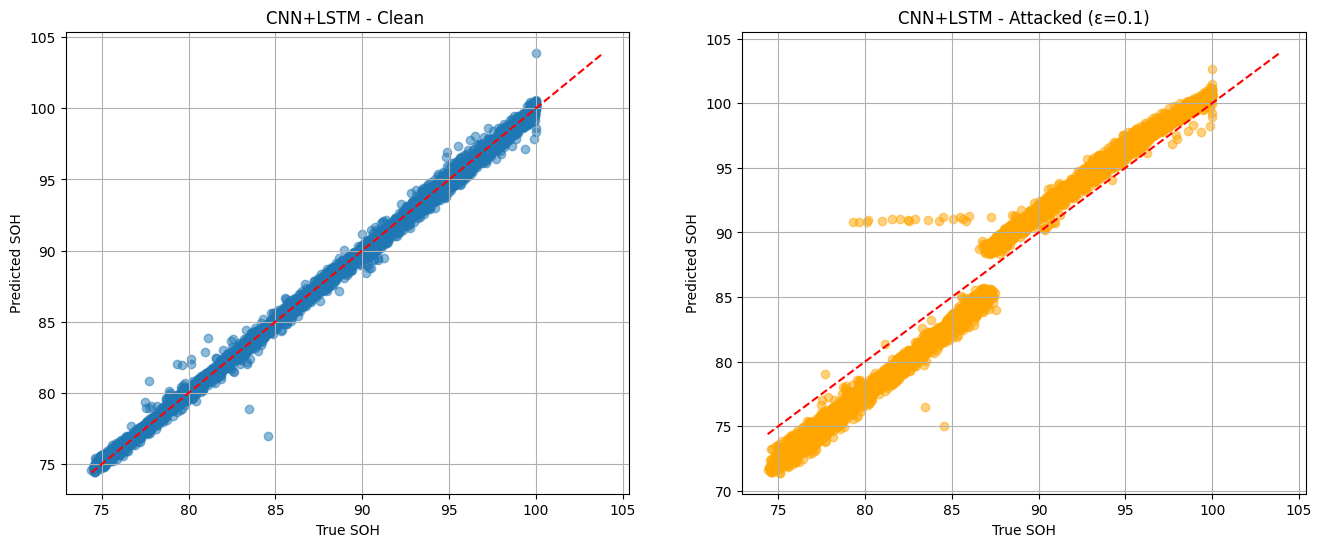

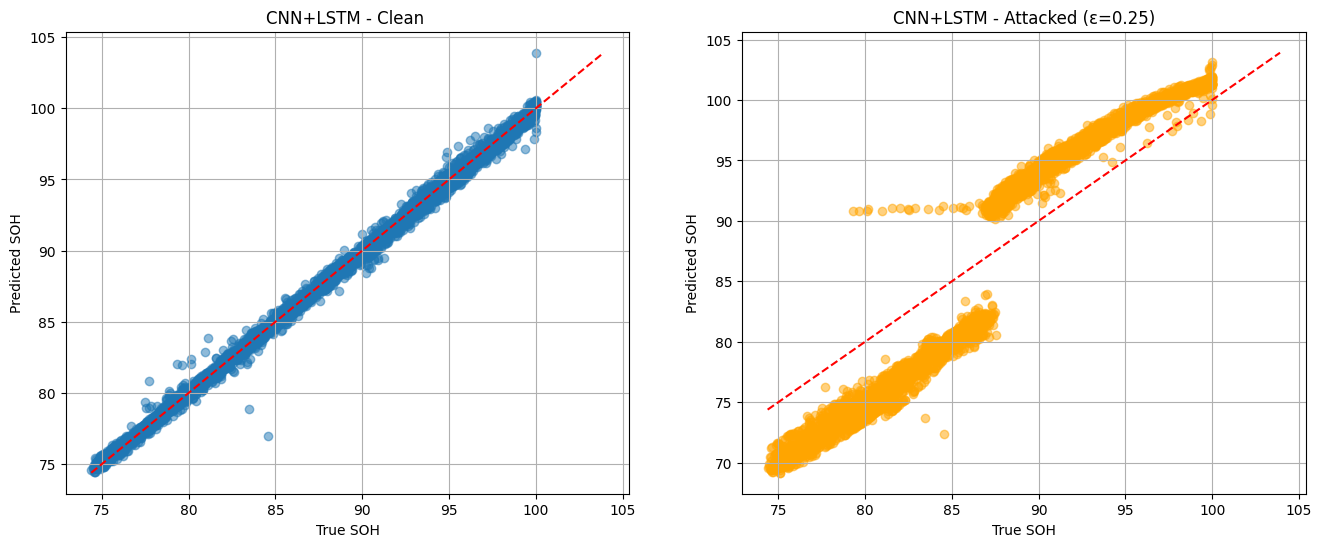

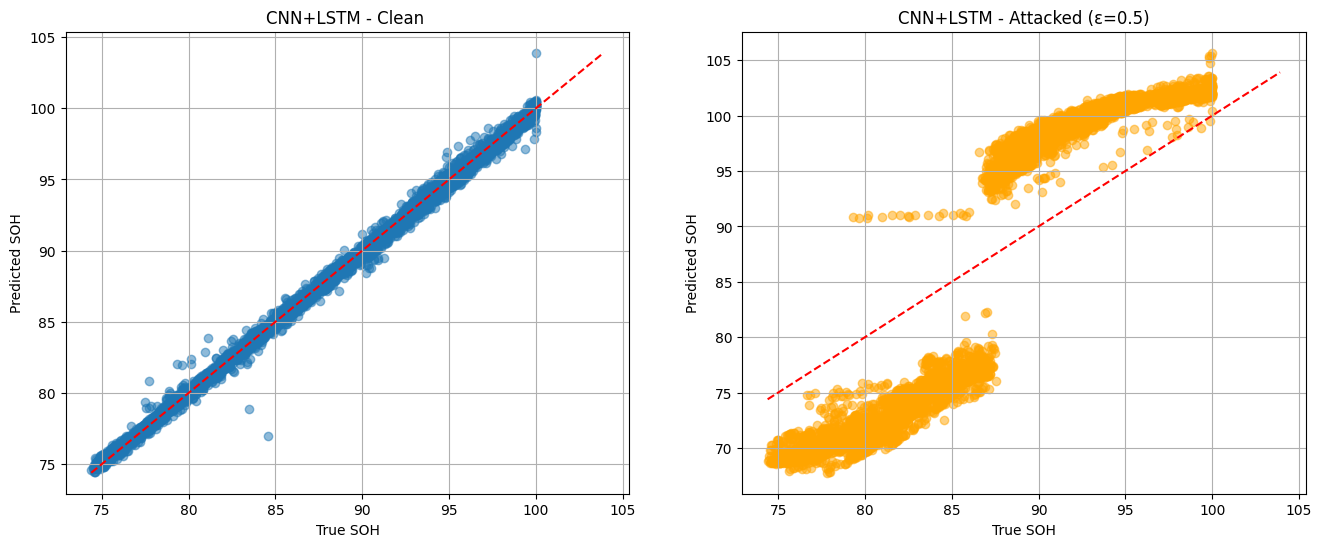

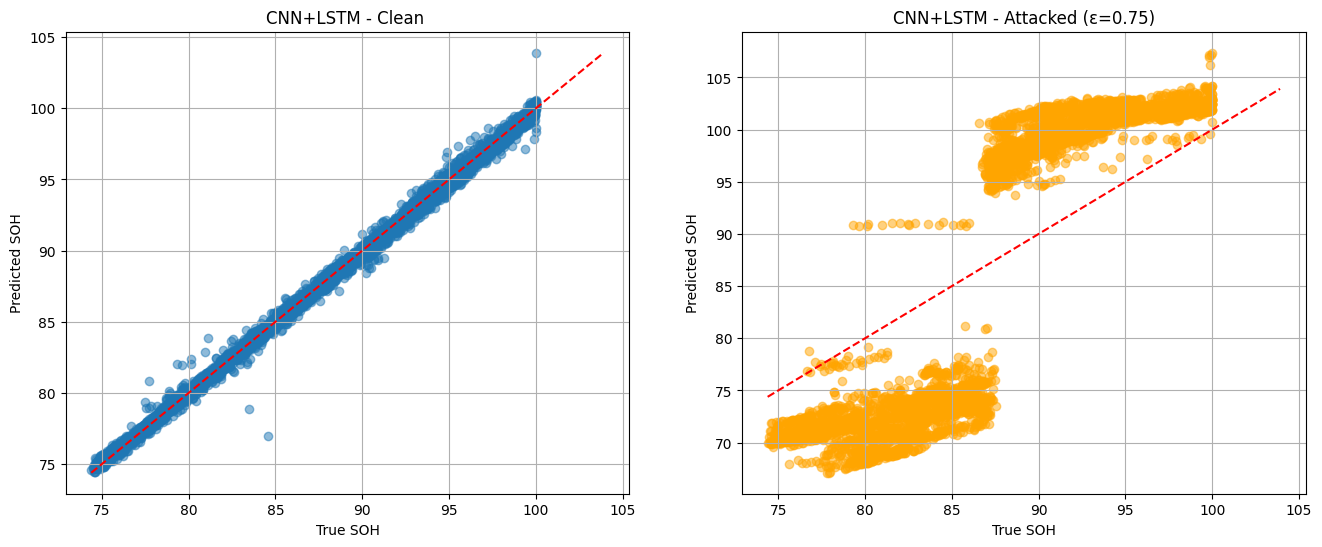

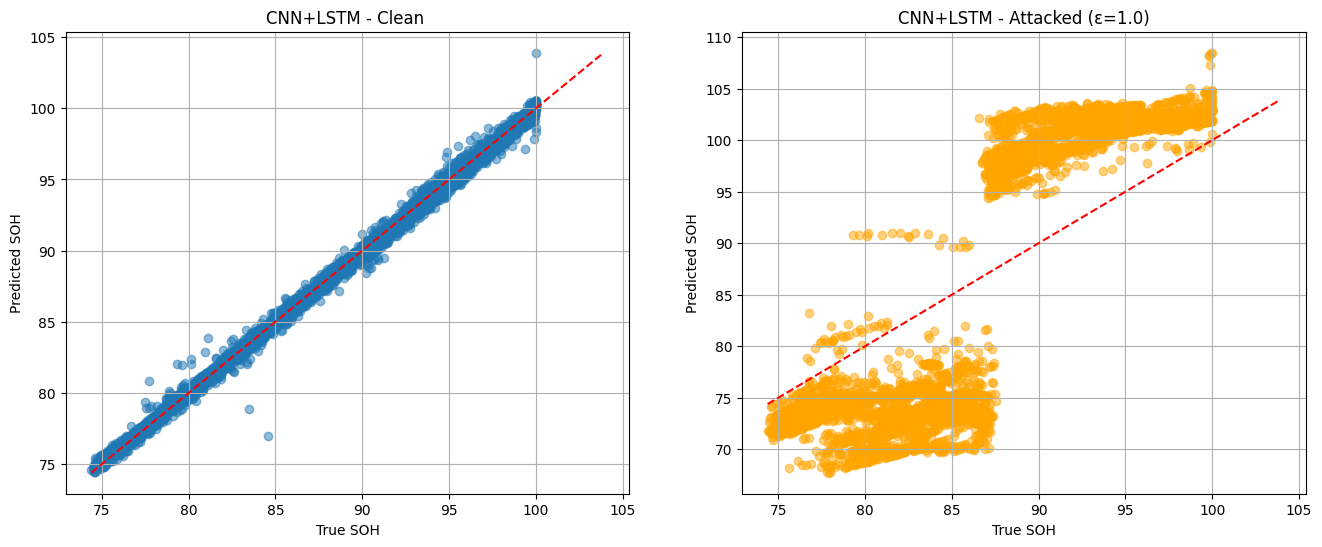

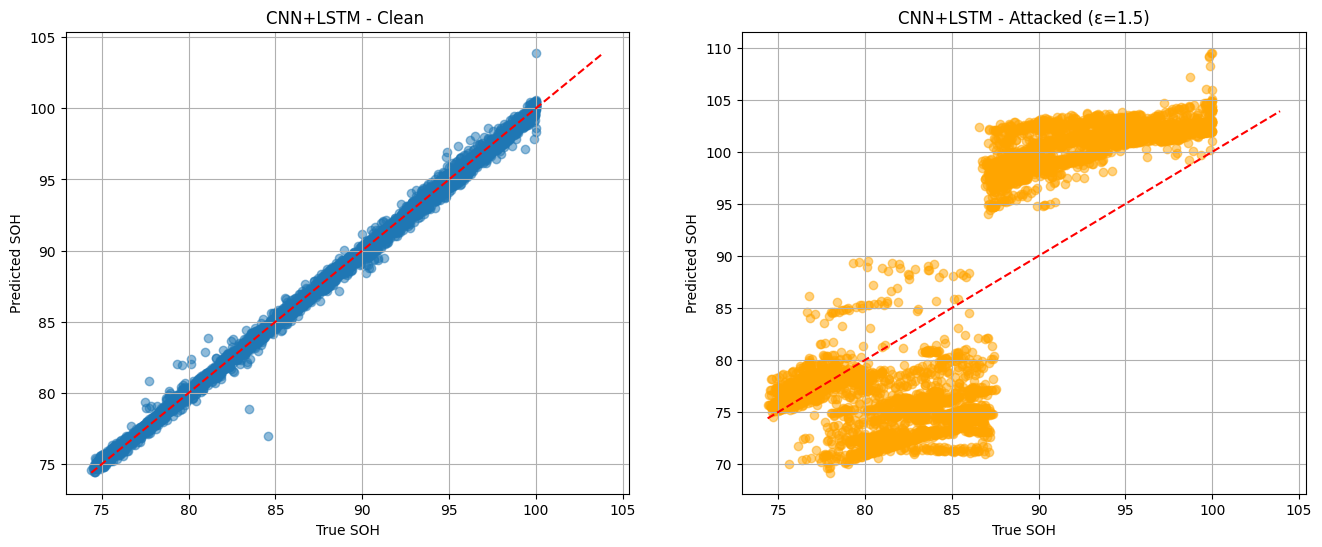

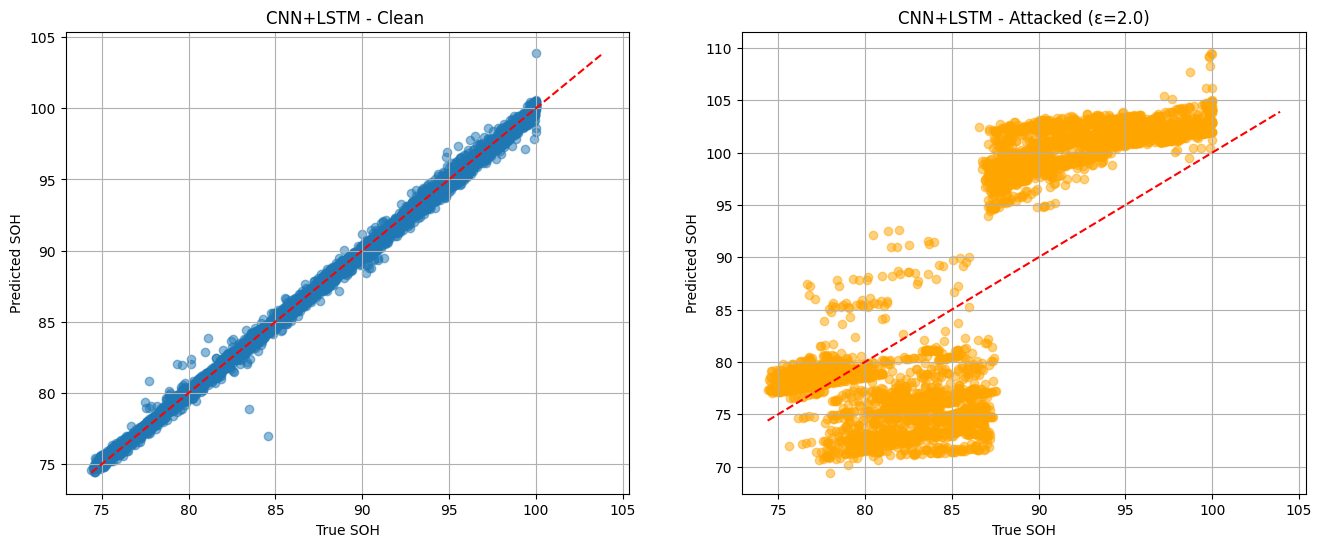


Adversarial Evaluation Results – CNN+LSTM
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.1000         0.2723            1.8851  1.6127          0.0031             0.0222
   0.2500         0.2723            4.3186  4.0463          0.0031             0.0506
   0.5000         0.2723            7.2711  6.9987          0.0031             0.0848
   0.7500         0.2723            8.3501  8.0777          0.0031             0.0970
   1.0000         0.2723            8.0110  7.7387          0.0031             0.0924
   1.5000         0.2723            7.2306  6.9583          0.0031             0.0827
   2.0000         0.2723            7.2192  6.9469          0.0031             0.0826


In [18]:
print("----------")
print("CNN + LSTM")
print("----------")

cnn_lstm = keras.models.load_model(r"../../Models/CNN_LSTM_NT.keras")

epsilon_physical_values = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

results_cnn_lstm = run_attack_evaluation(
    model=cnn_lstm,
    model_name="CNN+LSTM",
    attack_fn=fgsm_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

__CNN + GRU__

---------
CNN + GRU
---------


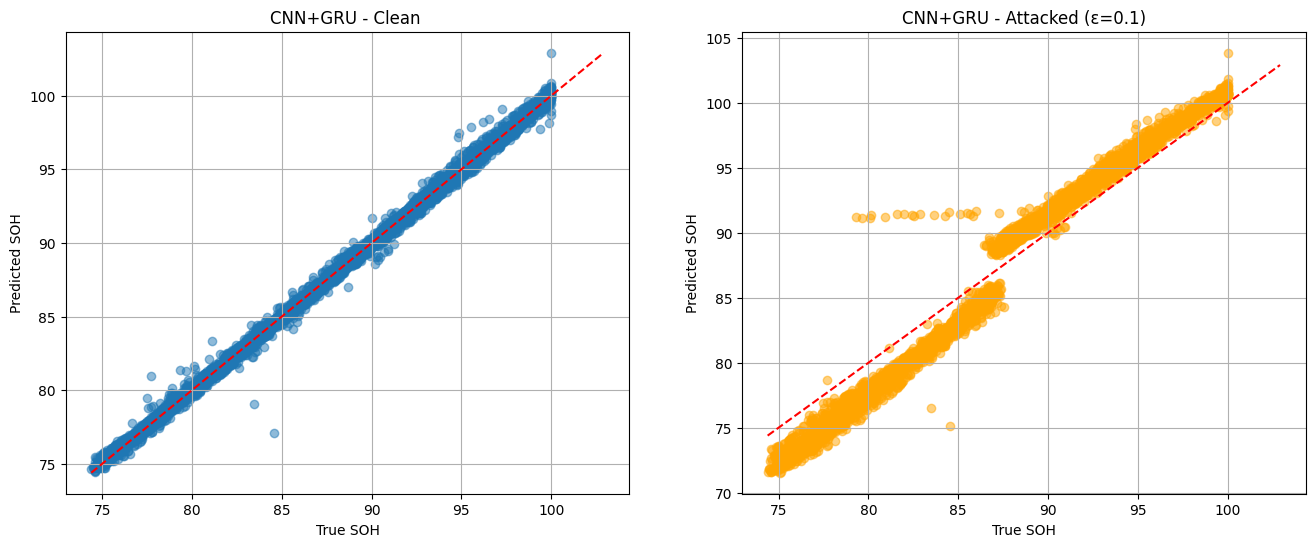

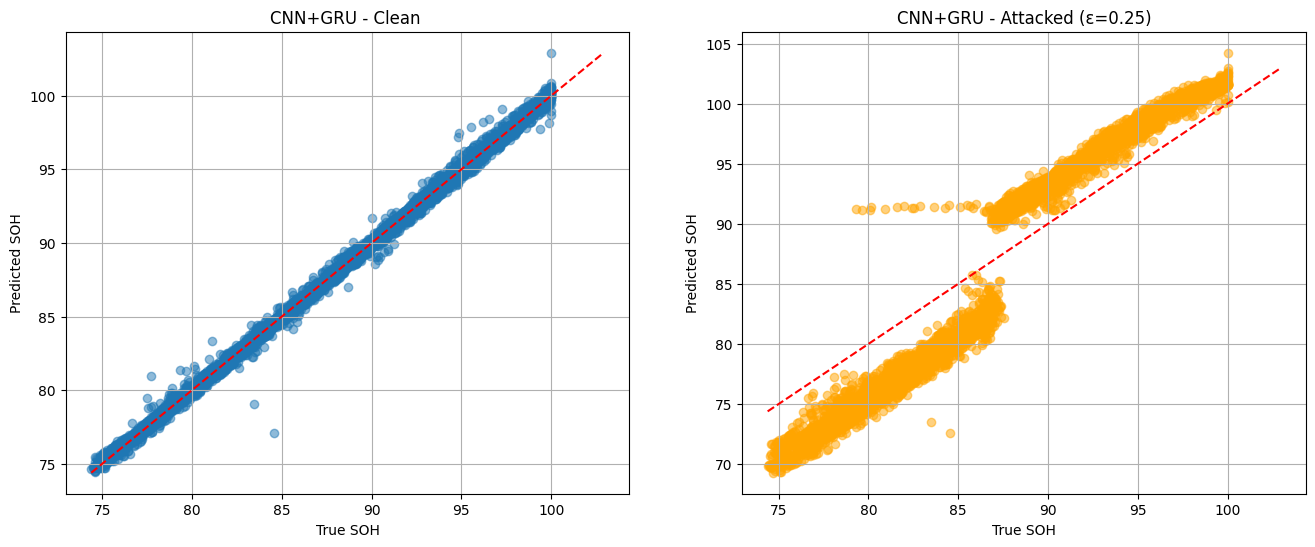

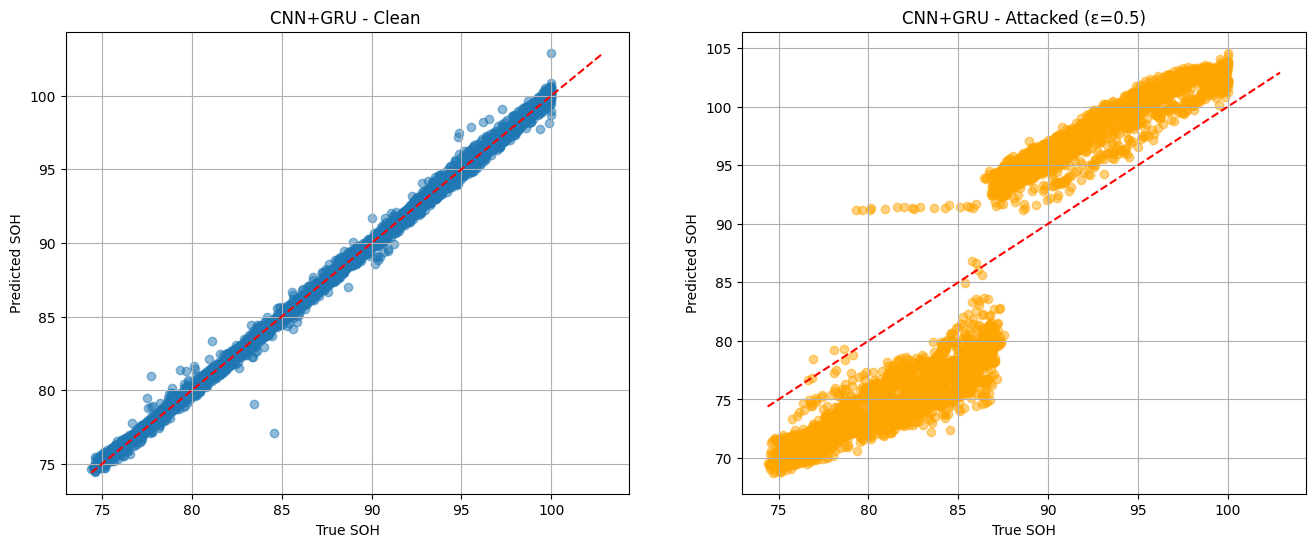

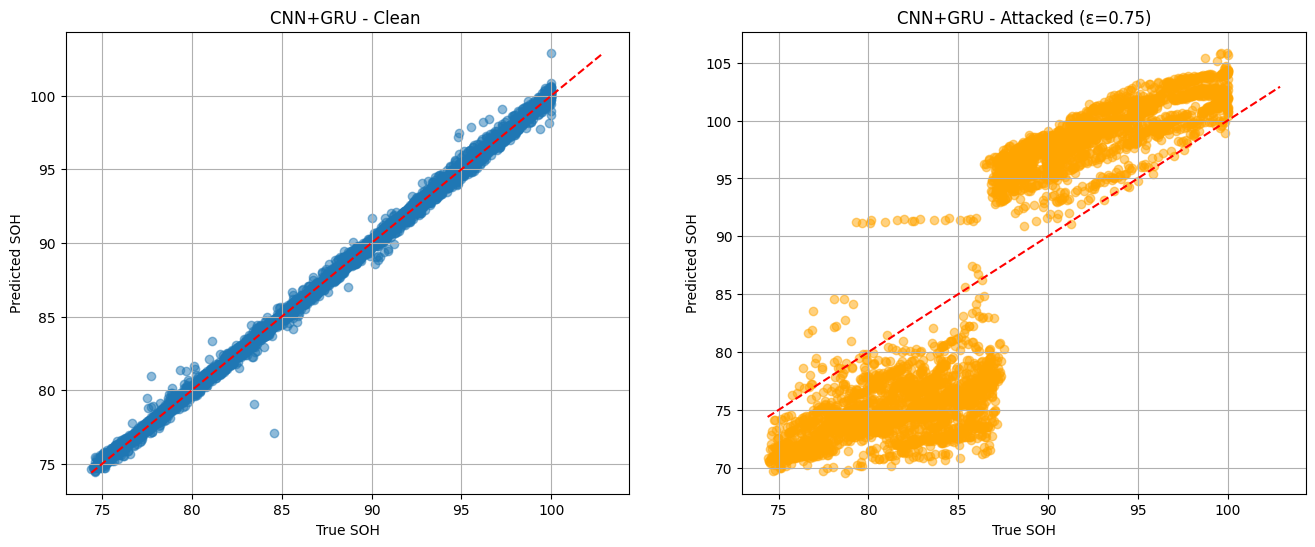

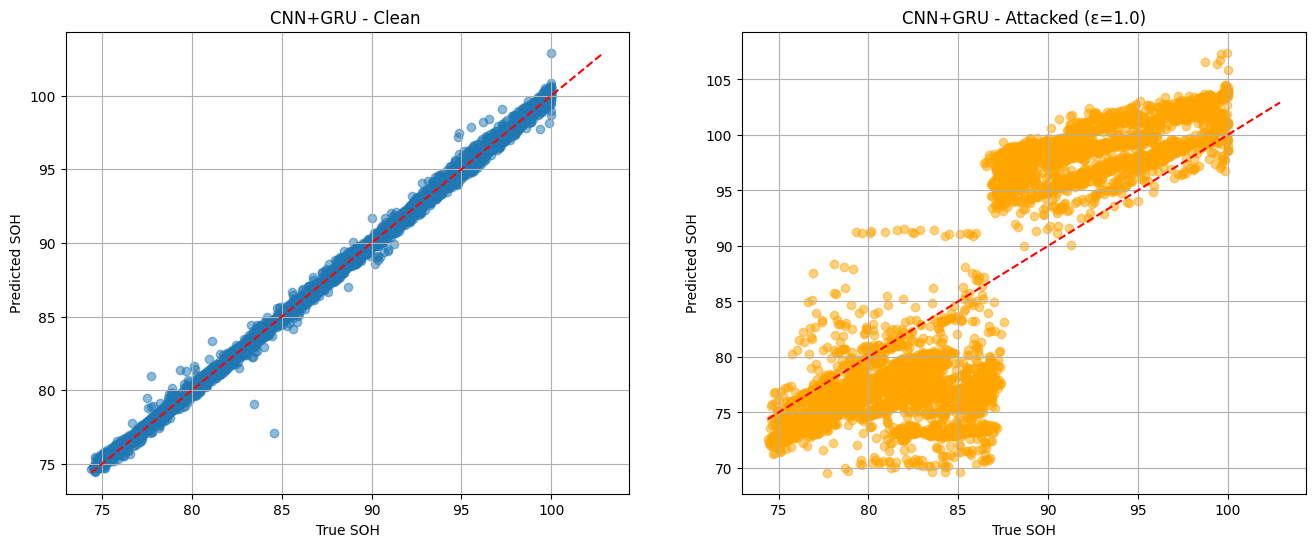

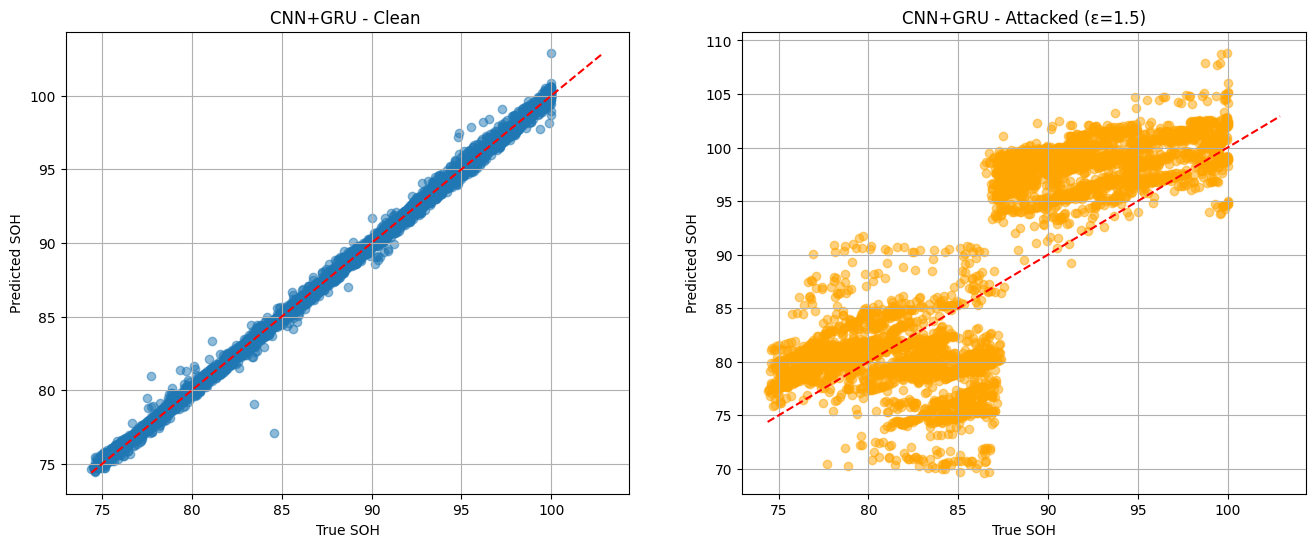

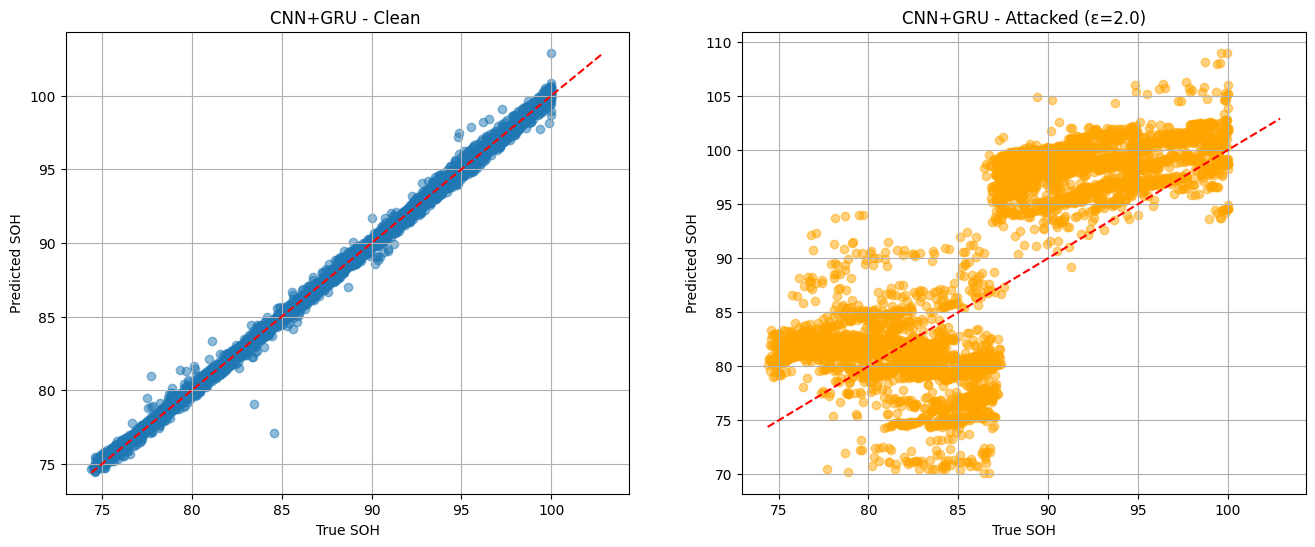


Adversarial Evaluation Results – CNN+GRU
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.1000         0.2500            1.8466  1.5966          0.0029             0.0218
   0.2500         0.2500            3.8252  3.5752          0.0029             0.0448
   0.5000         0.2500            5.8987  5.6488          0.0029             0.0686
   0.7500         0.2500            6.3294  6.0794          0.0029             0.0732
   1.0000         0.2500            5.6017  5.3518          0.0029             0.0642
   1.5000         0.2500            5.1633  4.9133          0.0029             0.0593
   2.0000         0.2500            5.4191  5.1691          0.0029             0.0626


In [19]:
print("---------")
print("CNN + GRU")
print("---------")
cnn_gru = keras.models.load_model(r"../../Models/CNN_GRU_NT.keras")

results_cnn_gru = run_attack_evaluation(
    model=cnn_gru,
    model_name="CNN+GRU",
    attack_fn=fgsm_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

__RCN__

---
RCN
---


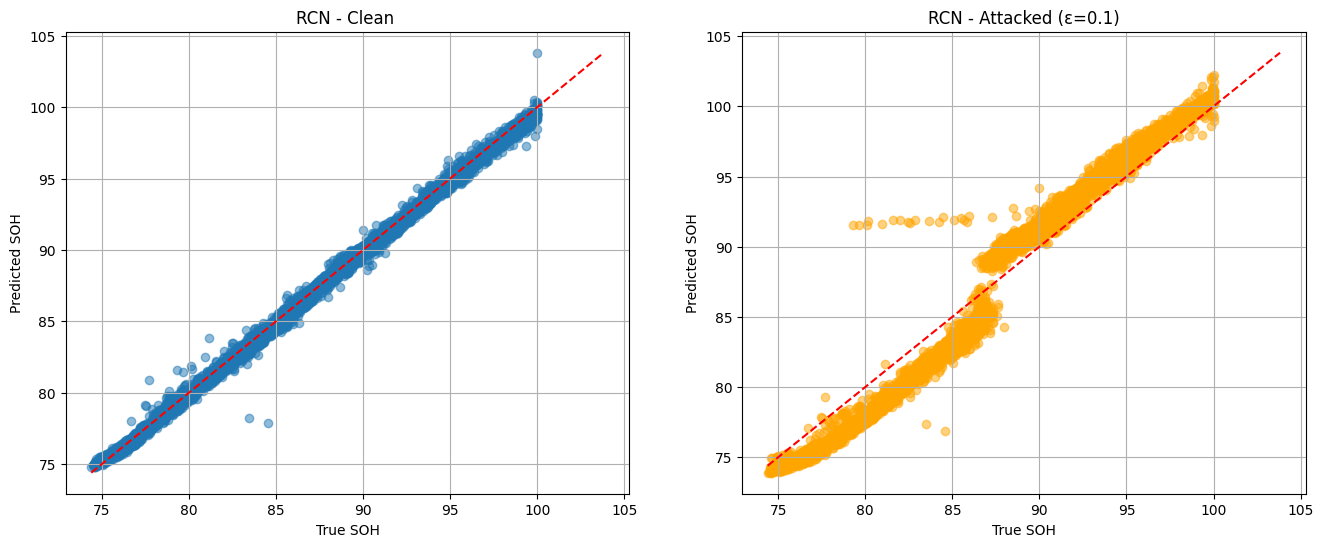

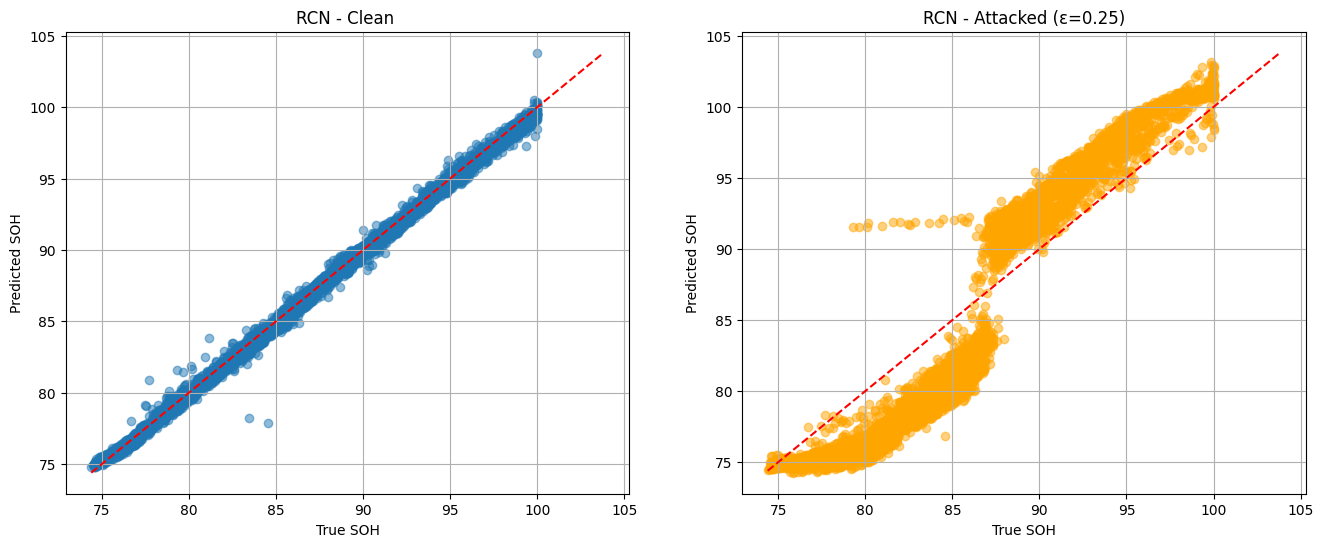

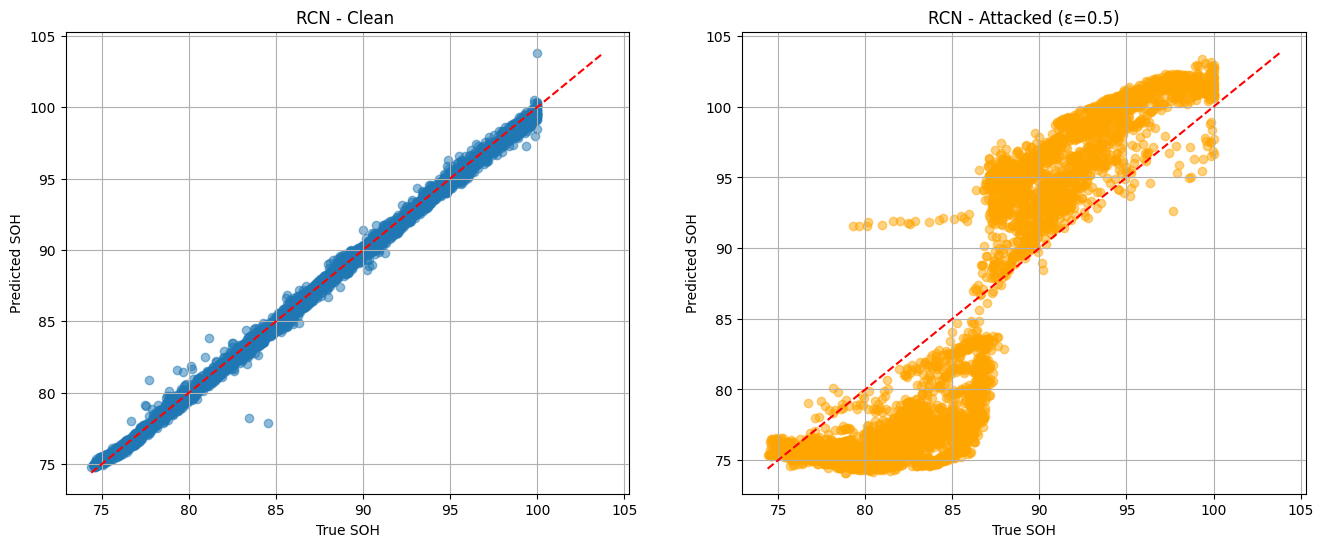

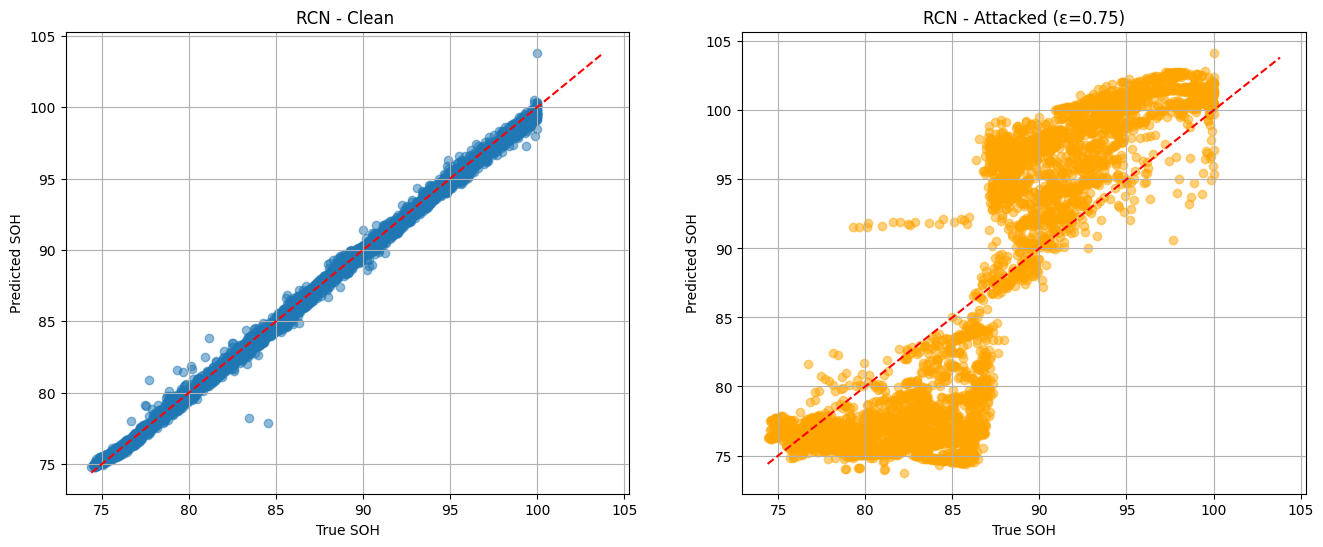

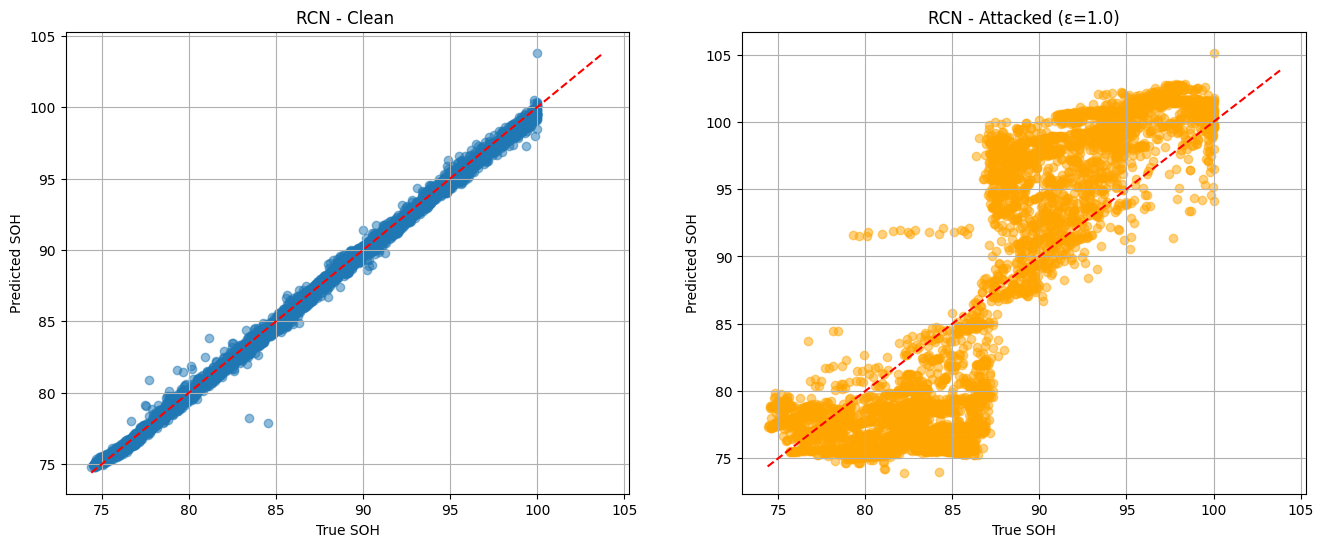

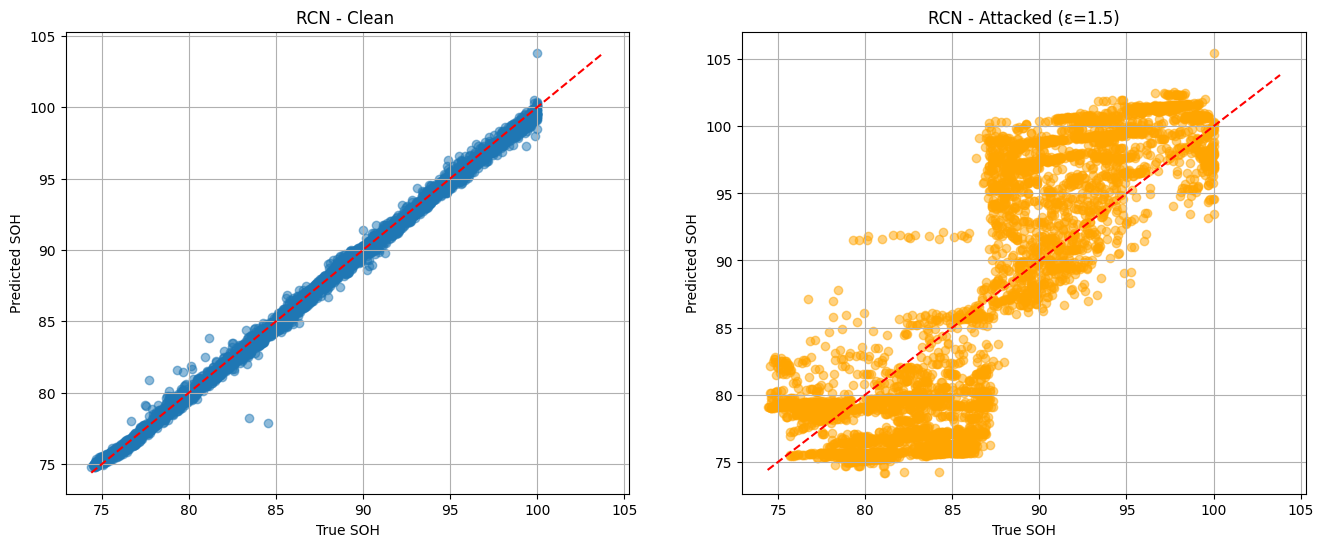

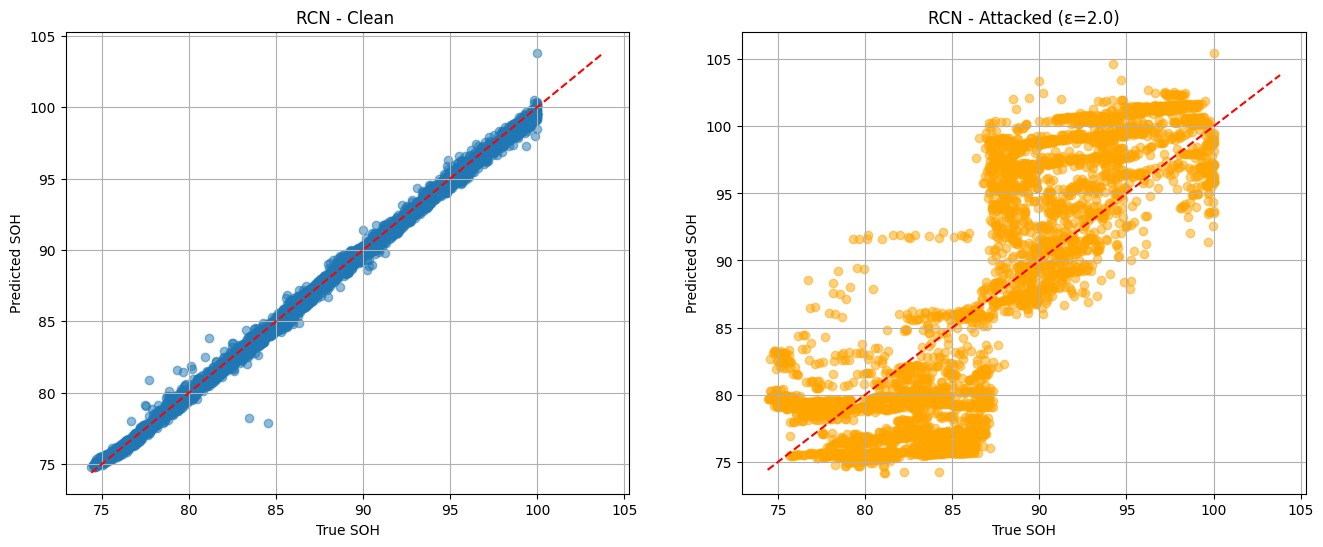


Adversarial Evaluation Results – RCN
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.1000         0.2750            1.6702  1.3952          0.0031             0.0195
   0.2500         0.2750            3.1841  2.9091          0.0031             0.0369
   0.5000         0.2750            4.5134  4.2384          0.0031             0.0519
   0.7500         0.2750            4.6233  4.3483          0.0031             0.0530
   1.0000         0.2750            4.4346  4.1596          0.0031             0.0509
   1.5000         0.2750            4.4234  4.1484          0.0031             0.0510
   2.0000         0.2750            4.4661  4.1911          0.0031             0.0515


In [20]:
print("---")
print("RCN")
print("---")

rcn = keras.models.load_model(r"../../Models/RCN_NT.keras")

results_rcn = run_attack_evaluation(
    model=rcn,
    model_name="RCN",
    attack_fn=fgsm_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

__CNN__

---
CNN
---


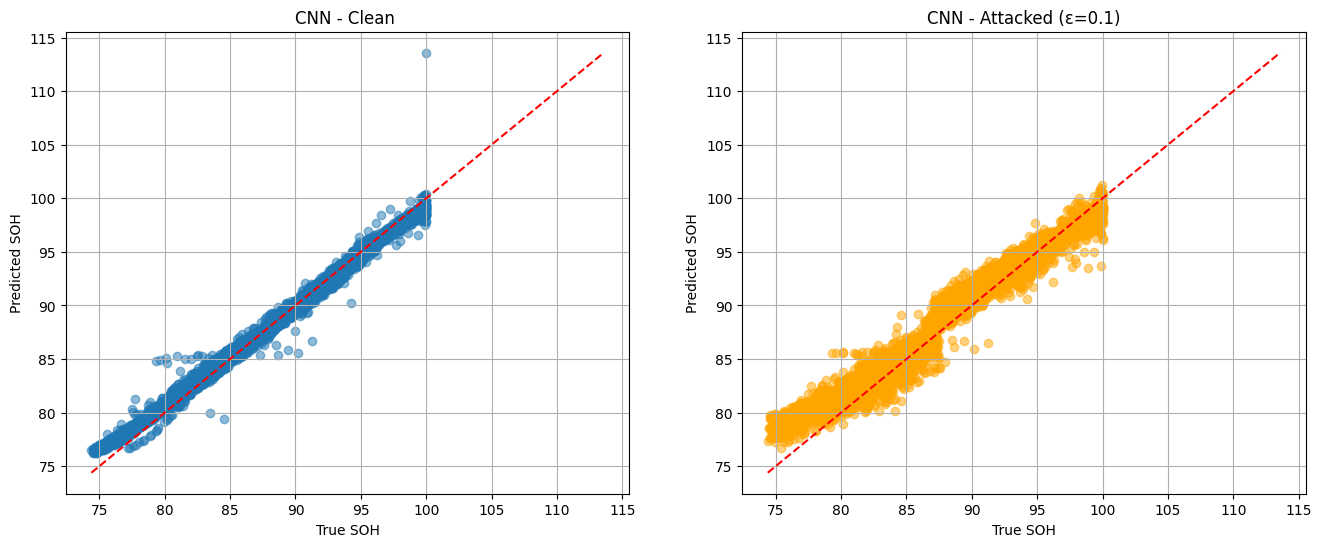

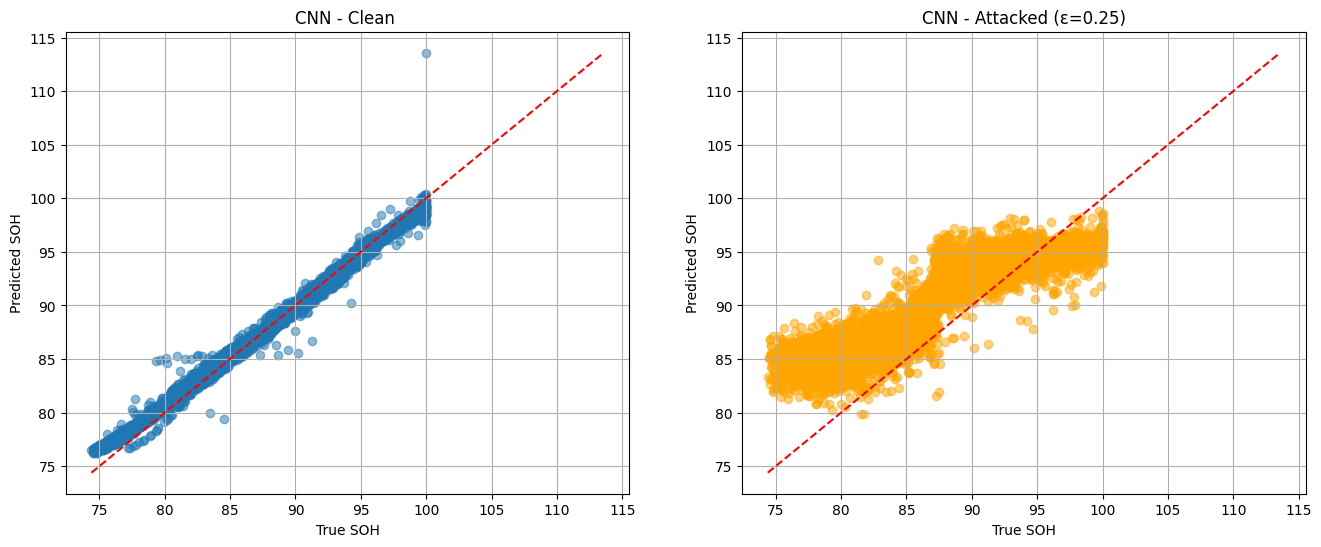

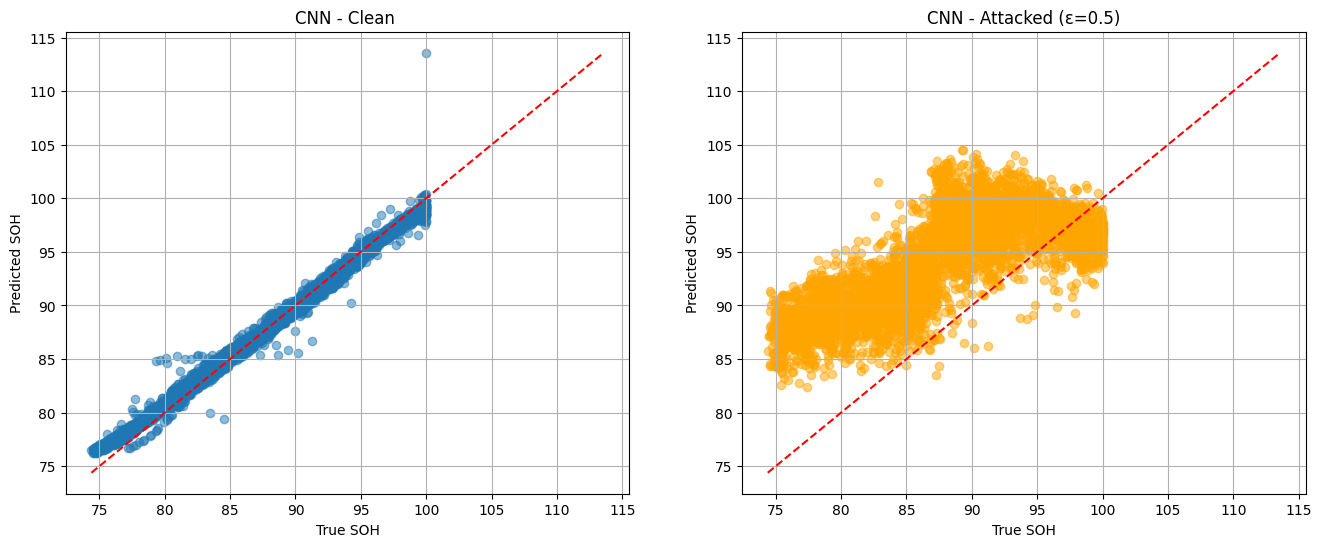

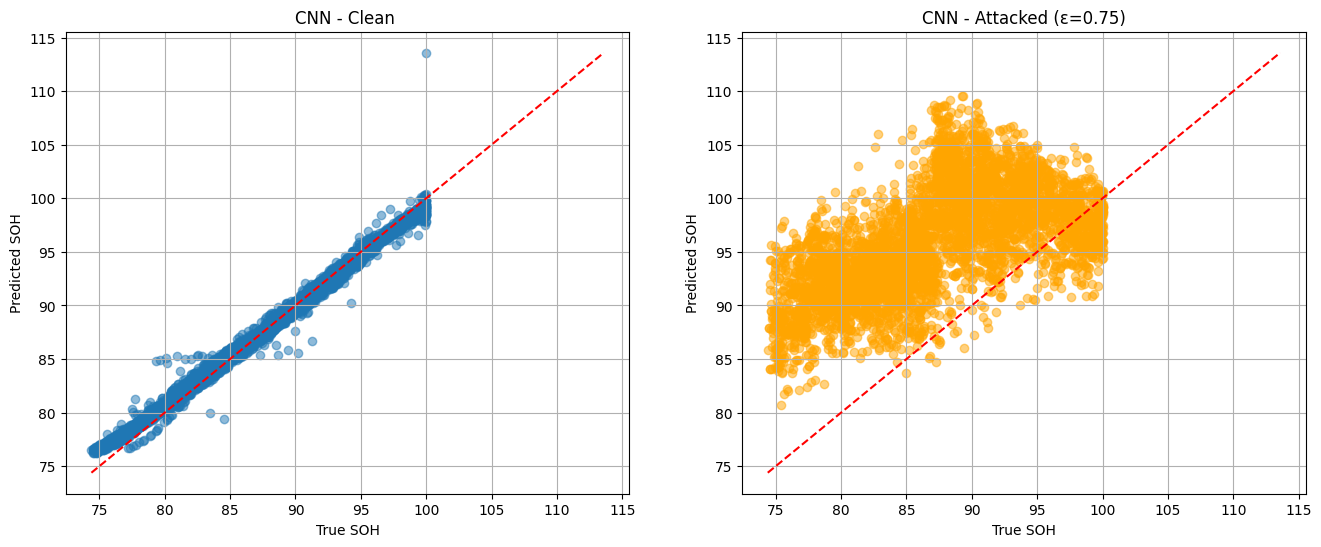

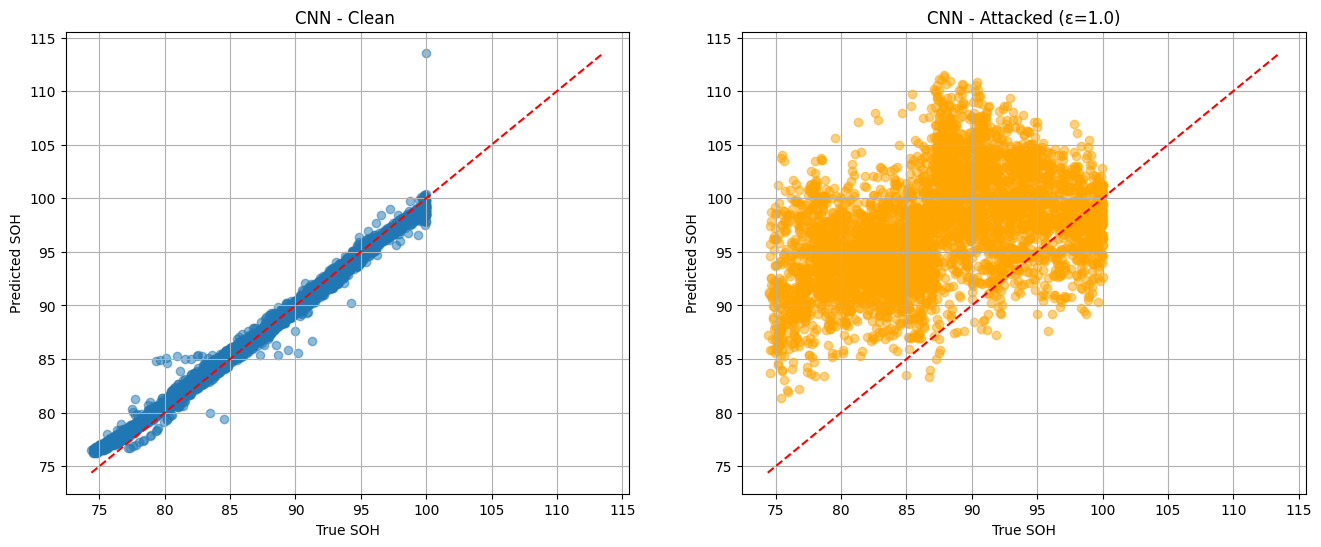

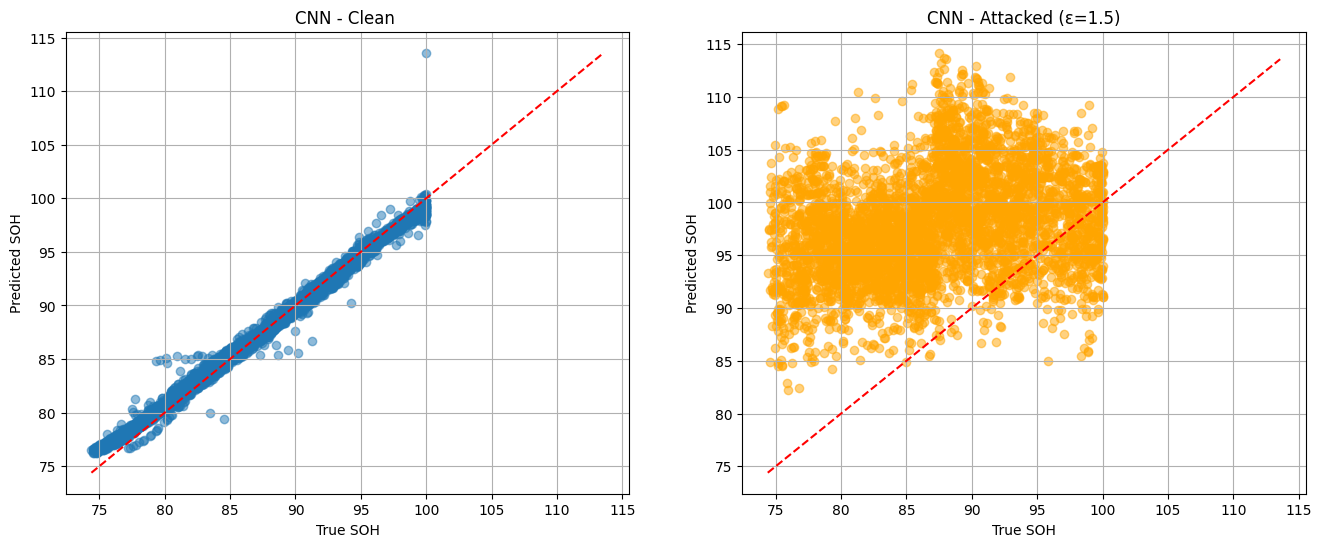

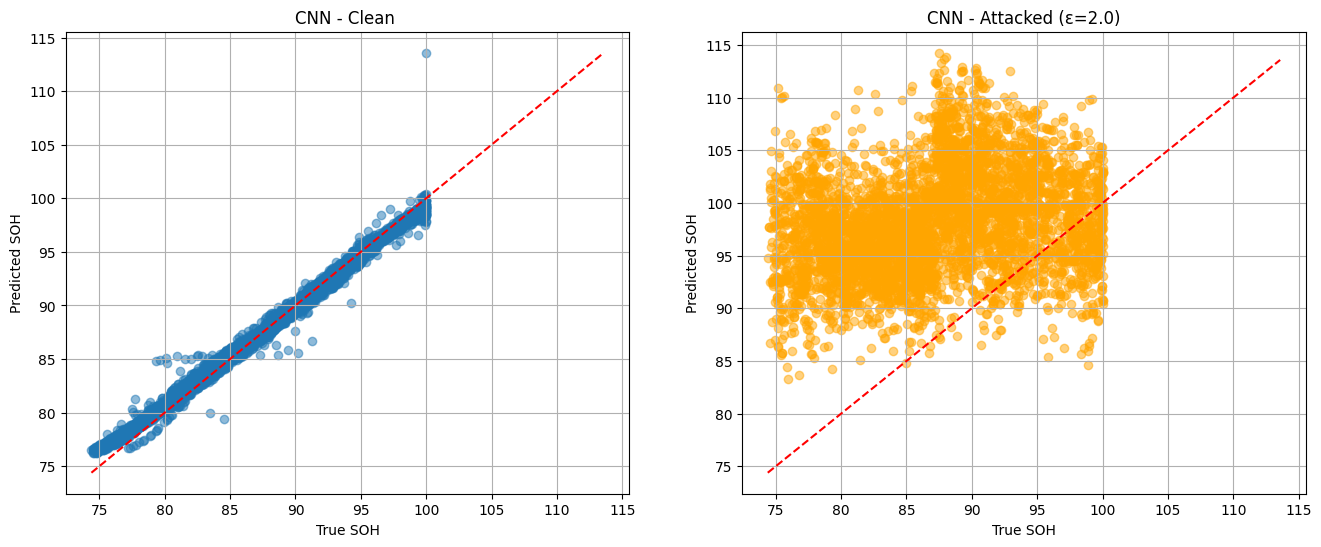


Adversarial Evaluation Results – CNN
  Epsilon    MAE (Clean)    MAE (Attacked)     ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  -------  --------------  -----------------
   0.1000         0.5964            1.2475   0.6511          0.0071             0.0148
   0.2500         0.5964            3.8414   3.2450          0.0071             0.0457
   0.5000         0.5964            7.1393   6.5430          0.0071             0.0846
   0.7500         0.5964            9.1751   8.5787          0.0071             0.1087
   1.0000         0.5964           10.3180   9.7217          0.0071             0.1225
   1.5000         0.5964           11.3032  10.7068          0.0071             0.1344
   2.0000         0.5964           11.5627  10.9663          0.0071             0.1376


In [21]:
print("---")
print("CNN")
print("---")

cnn = keras.models.load_model(r"../../Models/CNN_NT.keras")

results_cnn = run_attack_evaluation(
    model=cnn,
    model_name="CNN",
    attack_fn=fgsm_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

In [24]:
idx = 100   
epsilon = 0.1
orig_ic = X_ic_test[idx].reshape(-1)     
orig_ctx = X_context_test[idx].reshape(1,-1)
orig_true = y_test_norm[idx] * y_std + y_mean

adv_ic = fgsm_attack_batch(
    cnn_gru,
    X_ic_test[idx:idx+1],     
    X_context_test[idx:idx+1],
    y_test_norm[idx:idx+1],
    preprocessor.ic_scaler.scale_,
    0.1,
    clip_min,
    clip_max
).numpy()

adv_ic = adv_ic.reshape(-1)

y_pred_orig = cnn_gru.predict([X_ic_test[idx:idx+1], X_context_test[idx:idx+1]], verbose=0)[0][0]
y_pred_adv  = cnn_gru.predict([adv_ic.reshape(1,-1,1), X_context_test[idx:idx+1]], verbose=0)[0][0]

y_pred_orig = y_pred_orig * y_std + y_mean
y_pred_adv = y_pred_adv * y_std + y_mean

orig_true = orig_true * y_std + y_mean

print("Original pred:", y_pred_orig)
print("Adversarial pred:", y_pred_adv)
print("True value:", orig_true)

Original pred: 86.04521572630256
Adversarial pred: 84.1435131480039
True value: 661.607976271028


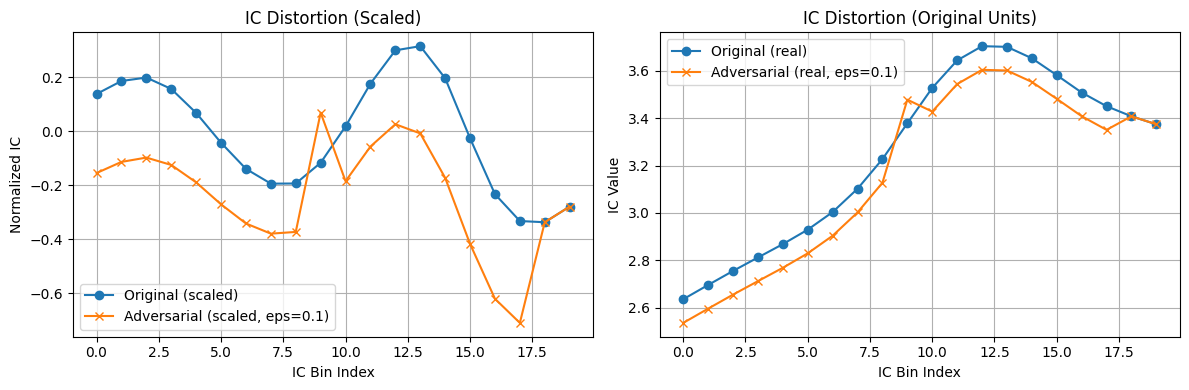

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ensure numpy 1D
orig_ic_np = np.asarray(orig_ic).reshape(-1)
adv_ic_np  = np.asarray(adv_ic).reshape(-1)

# from your fitted scaler
ic_mean = preprocessor.ic_scaler.mean_      # shape (20,)
ic_std  = preprocessor.ic_scaler.scale_     # shape (20,)

# inverse-transform to original IC units
orig_ic_real = orig_ic_np * ic_std + ic_mean
adv_ic_real  = adv_ic_np  * ic_std + ic_mean

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Scaled
ax[0].plot(orig_ic_np, marker='o', label='Original (scaled)')
ax[0].plot(adv_ic_np, marker='x', label=f'Adversarial (scaled, eps={epsilon})')
ax[0].set_title('IC Distortion (Scaled)')
ax[0].set_xlabel('IC Bin Index')
ax[0].set_ylabel('Normalized IC')
ax[0].grid(True)
ax[0].legend()

# Original units
ax[1].plot(orig_ic_real, marker='o', label='Original (real)')
ax[1].plot(adv_ic_real, marker='x', label=f'Adversarial (real, eps={epsilon})')
ax[1].set_title('IC Distortion (Original Units)')
ax[1].set_xlabel('IC Bin Index')
ax[1].set_ylabel('IC Value')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


In [28]:
print("Original IC :", orig_ic_real)
print("Adversarial IC ", adv_ic_real)

Original IC : [2.63544703 2.69571938 2.75490791 2.81182622 2.86827362 2.9293879
 3.00376949 3.10226877 3.22759195 3.37872811 3.52842484 3.64460935
 3.70479718 3.7019922  3.65372201 3.58225113 3.50893358 3.45112486
 3.40843957 3.37470359]
Adversarial IC  [2.53544702 2.59571938 2.65490791 2.71182622 2.76827362 2.8293879
 2.90376948 3.00226876 3.12759194 3.4787281  3.42842483 3.54460935
 3.60479718 3.60199219 3.55372201 3.48225112 3.40893358 3.35112486
 3.40843957 3.3747036 ]
